In [1]:
import numpy as np
import plots
from Generators.NBL_Diracs import NBL_Diracs
from Samplers.IAF_FRI import IAF_FRI

In [2]:
dur = 8

dt = 0.01

B = 1

K = 1

w_0 = 0.01

k_pi = 0

L_support = 2 * (1 + k_pi * np.pi / w_0)
N_E_spline = int(L_support / dt)

K_channels = 1

In [3]:
nbl_diracs = NBL_Diracs(dur, dt, L_support, B, K)
t, u = nbl_diracs.generate()

In [4]:
threshold = 0.12

In [5]:
iaf_fri = IAF_FRI(threshold, w_0, k_pi, K_channels)

iaf_fri.setSignal(t, u, dt)

spikes = iaf_fri.encode()

# u_rec = iaf_fri.decode()

iaf_fri.summary()

Integrate-and-Fire Sampler - FRI
From "TIME ENCODING AND PERFECT RECOVERY OF NON-BANDLIMITED SIGNALS WITH AN INTEGRATE-AND-FIRE SYSTEM"
Roxana Alexandru, Pier Luigi Dragotti, 2019
Status: ENCODED
Parameters:
Frequency 'w_0': 0.01
Number of pis 'k_pi': 0
Number of channels 'K_channels': 1
Support of E-spline filter 'L_support': 2.0


/home/ghassenk/Environments/Python/anaconda3/lib/python3.7/site-packages/scipy/signal/waveforms.py:658: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif idx == 'mid':


/home/ghassenk/Bureau/EPFL/Master2/Semester Project - ICNS/plots.py:50: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(t, u)


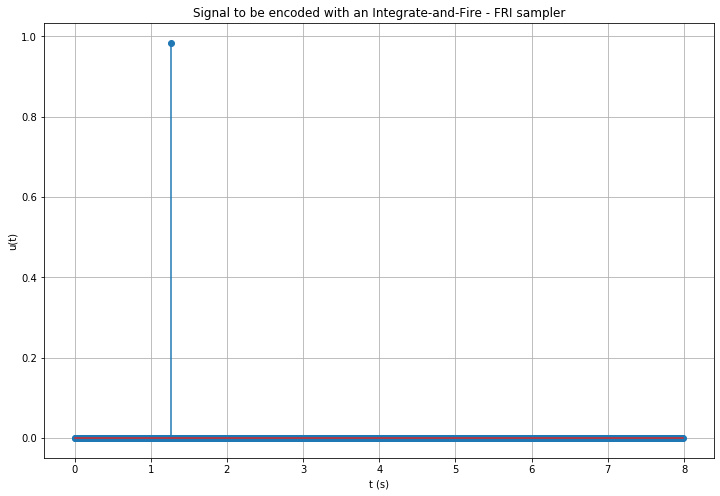

In [6]:
iaf_fri.plotSignal()

In [7]:
# iaf_fri.plotRecoveredSignal()

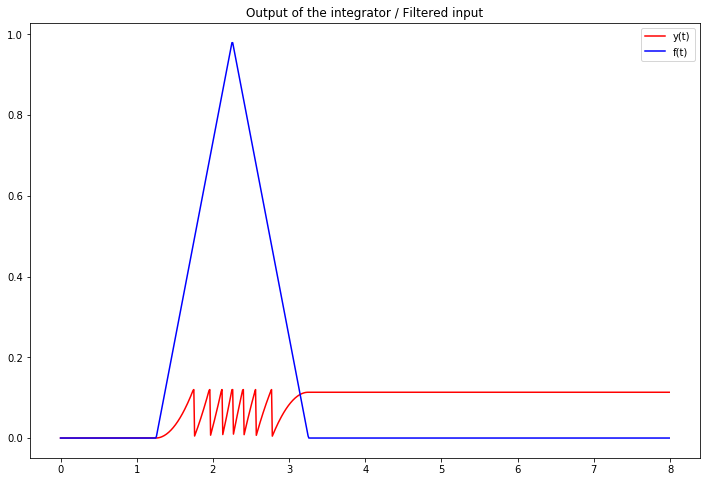

In [8]:
iaf_fri.plotIntegralAndEncoderOutput()

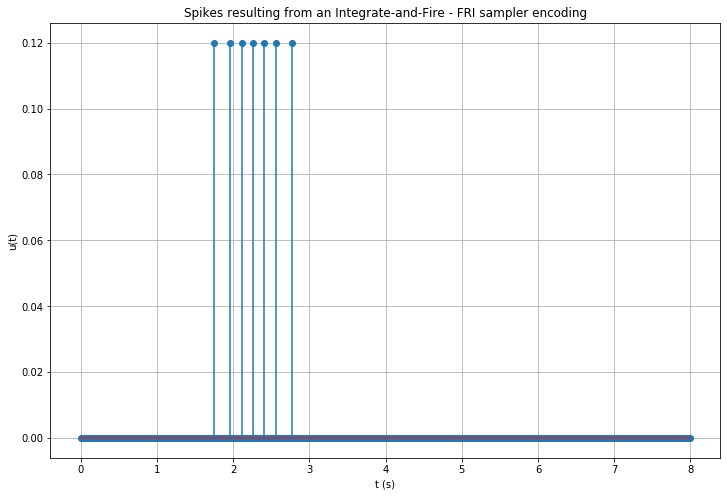

In [9]:
iaf_fri.plotSpikes()

In [10]:
iaf_fri.spikes_idx

array([175, 196, 212, 226, 240, 256, 277])

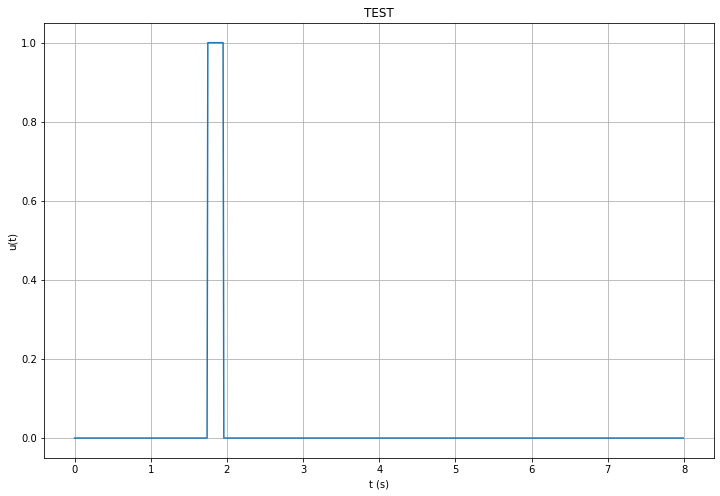

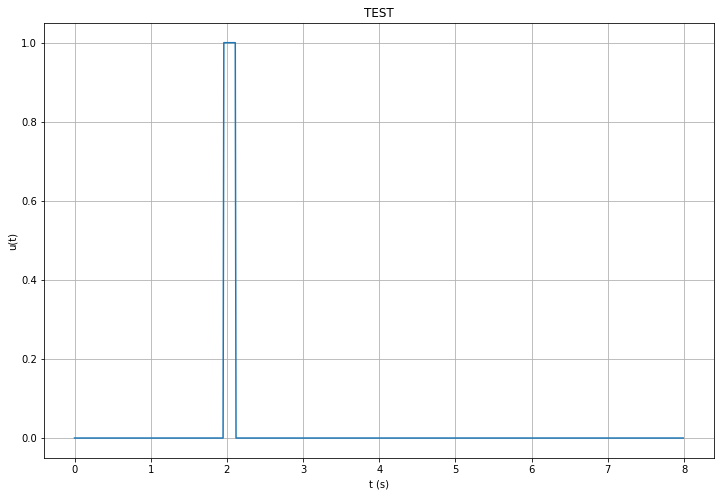

In [11]:
q1 = np.zeros(u.shape[0])
q2 = np.zeros(u.shape[0])
t0_idx = iaf_fri.spikes_idx[0]
t1_idx = iaf_fri.spikes_idx[1]
t2_idx = iaf_fri.spikes_idx[2]
q1[t0_idx : t1_idx] = 1
q2[t1_idx : t2_idx] = 1
plots.plotAny(t, q1, 'TEST')
plots.plotAny(t, q2, 'TEST')

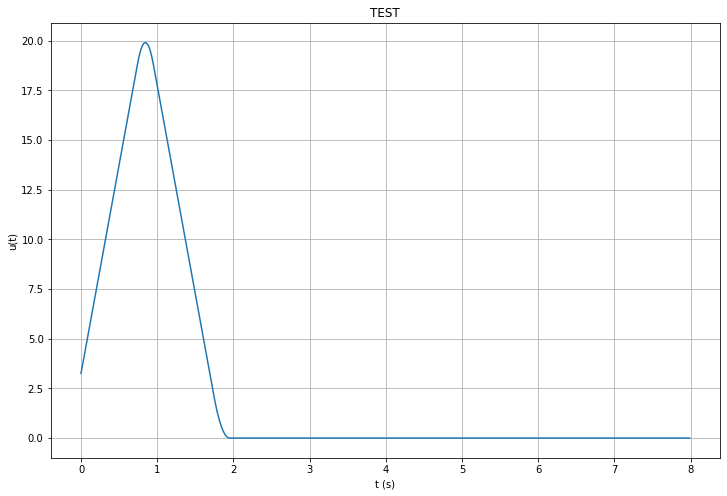

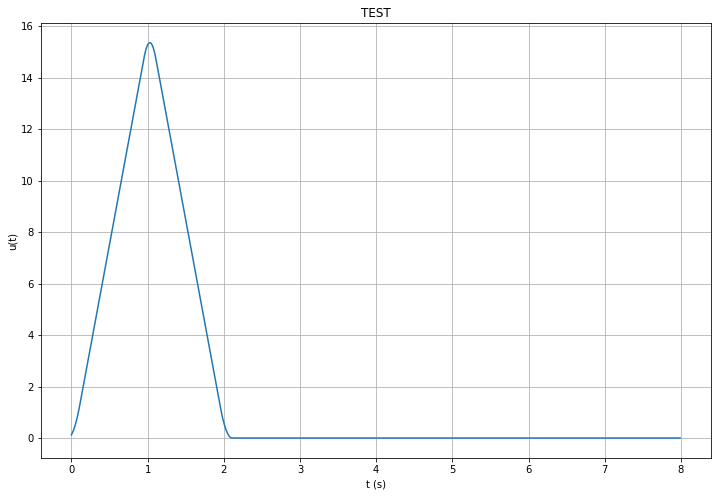

In [12]:
phi_1 = np.convolve(q1, iaf_fri.filter)[int(t.shape[0]/2): -int(t.shape[0]/2)+1]
phi_2 = np.convolve(q2, iaf_fri.filter)[int(t.shape[0]/2): -int(t.shape[0]/2)+1]
plots.plotAny(t, phi_1, 'TEST')
plots.plotAny(t, phi_2, 'TEST')

In [13]:
half_N_E_spline = int(iaf_fri.N_E_spline/2)

p1 = t2_idx - N_E_spline
p2 = t1_idx - half_N_E_spline

print(p1)
print(p2)

12
96


In [14]:
print(phi_1[p1])
print(phi_1[p2])
print(phi_2[p1])
print(phi_2[p2])

5.774991662346876
18.584753989802376
1.4399996525993206
14.86978442474955


In [15]:
c2 = (phi_1[p1] * np.exp(1j * w_0 * iaf_fri.t[p2])) / (phi_1[p1] * phi_2[p2])
c1 = (np.exp(1j * w_0 * iaf_fri.t[p1]) - c2 * phi_2[p1]) / phi_1[p1]
print(c1)
print(c2)

(0.15639210251995167+4.681283133382692e-05j)
(0.06724737170295159+0.0006455946011363351j)


In [16]:
d2 = (phi_1[p1] * np.exp(- 1j * w_0 * iaf_fri.t[p2])) / (phi_1[p1] * phi_2[p2])
d1 = (np.exp(- 1j * w_0 * iaf_fri.t[p1]) - c2 * phi_2[p1]) / phi_1[p1]
print(d1)
print(d2)

(0.15639210251995167-0.0003687720845108333j)
(0.06724737170295159-0.0006455946011363351j)


In [17]:
s0 = c1 * threshold + c2 * threshold
s1 = d1 * threshold + d2 * threshold

In [18]:
print(s0)
print(s1)

(0.02683673690674839+8.308889189641945e-05j)
(0.02683673690674839-0.0001217240022776602j)


In [19]:
np.log(s0/s1)/(2*1j*w_0)

(0.38158848200090134+0.00027467143381821013j)

In [20]:
t0 = iaf_fri.spikes_timings[0]
t1 = iaf_fri.spikes_timings[1]
t2 = iaf_fri.spikes_timings[2]

d1 = t2 - L_support
d2 = t1 - L_support/2

alpha_0 = 1j * w_0
alpha_1 = - alpha_0

phi_1_left = (np.exp(alpha_0 * t1) - np.exp(alpha_0 * t0)) / (alpha_0 * (alpha_0 - alpha_1))
phi_1_right = (np.exp(alpha_1 * t1) - np.exp(alpha_1 * t0)) / (alpha_1 * (alpha_1 - alpha_0))

phi_2_left = (np.exp(alpha_0 * t2) - np.exp(alpha_0 * t1)) / (alpha_0 * (alpha_0 - alpha_1))
phi_2_right = (np.exp(alpha_1 * t2) - np.exp(alpha_1 * t1)) / (alpha_1 * (alpha_1 - alpha_0))

phi_1 = lambda d : phi_1_left * np.exp(- alpha_0 * d) + phi_1_right * np.exp(- alpha_1 * d)
phi_2 = lambda d : phi_2_left * np.exp(- alpha_0 * d) + phi_2_right * np.exp(- alpha_1 * d)

c_0_1 = (np.exp(- alpha_0 * d2) * phi_2(d1) - np.exp(- alpha_0 * d1)) / (phi_1(d2) * phi_2(d1) - phi_1(d1))
c_0_2 = (np.exp(- alpha_0 * d1) - c_0_1 * phi_2(d2)) / (phi_2(d1))

c_1_1 = (np.exp(- alpha_1 * d2) * phi_2(d1) - np.exp(- alpha_1 * d1)) / (phi_1(d2) * phi_2(d1) - phi_1(d1))
c_1_2 = (np.exp(- alpha_1 * d1) - c_0_1 * phi_2(d2)) / (phi_2(d1))

In [21]:
phi_1(d1)

(0.36433165373796983+0j)

In [22]:
phi_1(d2)

(0.18794745626399367+0j)

In [23]:
phi_2(d1)

(0.3071810932142462+0j)

In [24]:
phi_2(d2)

(0.1727966223562926+0j)

In [25]:
print(t0)
print(t1)
print(t2)
print(w_0)

1.75
1.96
2.12
0.01


In [26]:
print(c_0_1)
print(c_0_2)

print(c_1_1)
print(c_1_2)

(2.2597437346461065+0.005704195464698785j)
(1.984247106111207-0.007115234204976421j)
(2.2597437346461065-0.005704195464698785j)
(1.984247106111207+0.0006977447739288429j)


In [27]:
s_0 = (c_0_1 + c_0_2) * threshold
s_1 = (c_1_1 + c_1_2) * threshold

print(s_0)
print(s_1)

(0.5092789008908776-0.0001693246488333163j)
(0.5092789008908776-0.000600774082892393j)


In [28]:
tau_1 = np.log(s_0/s_1) / (alpha_0 - alpha_1)
x_1 = s_0 / np.exp(alpha_0 * tau_1)

print(tau_1)
print(x_1)

(0.042358829402404166+3.2026142090286316e-05j)
(0.5092789465801106-0.0003850493313187009j)


In [29]:
from numpy import exp
from numpy.linalg import solve

A = np.zeros((2, 2), complex)

A[0, 0] = exp(alpha_0*t1)- exp(alpha_0*t0)
A[0, 1] = exp(alpha_0*t2)- exp(alpha_0*t1)
A[1, 0] = exp(alpha_1*t1)- exp(alpha_1*t0)
A[1, 1] = exp(alpha_1*t2)- exp(alpha_1*t1)

A = A *(1/(alpha_0*(alpha_0-alpha_1)))

B0 = np.array([1, 0])
B1 = np.array([0, 1])

c_0 = solve(A, B0)
c_1 = solve(A, B1)

c_0_1 = c_0[0]
c_0_2 = c_0[1]

c_1_1 = c_1[0]
c_1_2 = c_1[1]

In [30]:
print(A)

[[0.19476379-10.49819158j 0.16318866 -7.99833456j]
 [0.19476379+10.49819158j 0.16318866 +7.99833456j]]


In [31]:
print(c_0_1)
print(c_0_2)

print(c_1_1)
print(c_1_2)

(-25.734689349224514+0.5250605011391709j)
(33.77799427844071-0.6266536732138552j)
(-25.734689349224542-0.5250605011374342j)
(33.77799427844075+0.6266536732115758j)


In [32]:
s_0 = (c_0_1 + c_0_2) * threshold
s_1 = (c_1_1 + c_1_2) * threshold

print(s_0)
print(s_1)

(0.9651965915059433-0.012191180648962118j)
(0.9651965915059451+0.012191180648896996j)


In [33]:
tau_1 = np.log(s_0/s_1) / (alpha_0 - alpha_1)
x_1 = s_0 / np.exp(alpha_0 * tau_1)

print(tau_1)
print(x_1)

(-1.2630103033542794+5.668440135654323e-14j)
(0.9652735804632318-3.256857015121594e-14j)


In [34]:
# iaf_fri.plotSignalAndSpikes()

In [35]:
# iaf_fri.plotRecoveredSignalAndSpikes()

In [36]:
# iaf_fri.plotSignalAndRecoveredSignal()

In [37]:
# iaf_fri.plotError()

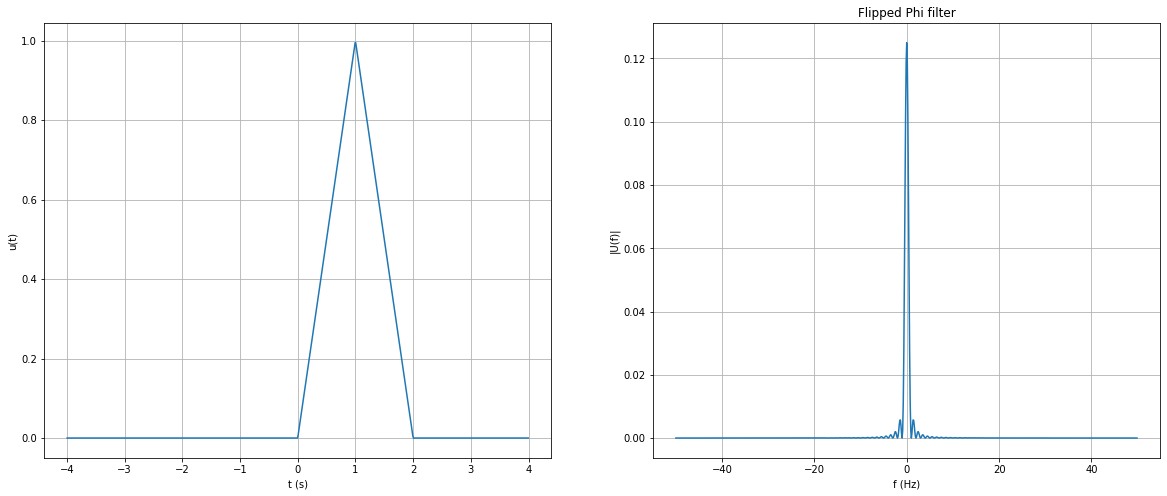

In [38]:
iaf_fri.plotFilter()

In [39]:
# print(f'The mean squared error of the signal is : {iaf_fri.computeMeanSquaredError()}')